# CMIP–Observations Comparison (Tutorial)

**Purpose**: Compare CMIP model output with local observations at a single point. This notebook demonstrates extracting observational and CMIP data using `climdata`, computing standard performance metrics (RMSE, Pearson correlation, MAPE, MNB), and producing visual summaries (boxplots + time series + portrait plot).

**Prerequisites**:
- `climdata` package
- Additional python packages: `cftime`, `hvplot`, `holoviews`, `bokeh`, `matplotlib`, `numpy`

**How to run**:
1. Run cells top-to-bottom in order. Edit the `overrides` blocks to change `dataset`, `lat`, `lon`, `time_range`, `variables`, and CMIP `source_id` list.
2. Outputs: an interactive HTML per variable (e.g. `distribution_tas.html`) and static portrait plot shown inline.

**Notes & tips**:
- The metrics function supports optional time resampling (e.g., `time_resample='MS'` for monthly means).

In [1]:
import climdata
import pandas as pd
import xarray as xr
import cftime
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s | %(message)s",
    force=True,
)

extractor = climdata.ClimData()

extractor_CMIP = climdata.CMIP(extractor.cfg)
print(extractor_CMIP.get_experiment_ids())
print(extractor_CMIP.get_source_ids('historical'))
print(extractor_CMIP.get_variables(experiment_id='historical',source_id=['GISS-E2-1-H','CanESM5','GFDL-ESM4']))


['historical', 'ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp585']


/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
INFO | 65 models found for experiment 'historical'


['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P-VHR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'ICON-ESM-LR', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2H', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL']
['hurs', 'pr', 'sfcWind', 'tas', 't

## Setup & imports 🔧

The first cell imports core packages used in this tutorial. If any imports fail, install requirements via:

```bash
# plotting support
pip install hvplot holoviews bokeh
```

If you are working on a cluster, ensure the `data_dir` and any data access permissions are correct before running extraction cells.

## Observational data extraction (step)

This cell demonstrates extracting local/observational data using `ClimData` with `overrides`.

- `dataset`: choose dataset (e.g., `hyras` or `mswx`)
- `lat`/`lon`: location for point extraction
- `time_range.start_date` and `.end_date`: extraction period
- `variables`: list of variable names to extract

After running this cell you should have:
- `ds_obs`: an xarray Dataset with observation variables
- `df_obs`: a Pandas long-form DataFrame (`time`, `variable`, `value`, `units`, `source`)

The notebook converts `time` values to `cftime.DatetimeNoLeap` where needed to support calendar-aware comparisons.

In [2]:
from climdata import ClimData
overrides = [
    "dataset=mswx",
    "lat=52",
    "lon=13",
    # "region=germany",
    f"time_range.start_date=1989-01-01",  # Start date for data extraction
    f"time_range.end_date=2014-12-31",    # End date for data extraction
    "variables=[tasmin,tasmax,pr,tas]",       # Variables to extract: min/max temp and precipitation
    "data_dir=/beegfs/muduchuru/data",    # Local directory to store raw/intermediate files
]
extractor = ClimData(overrides=overrides)
ds_obs = extractor.extract()
df_obs = extractor.to_dataframe()
df_obs['time'] = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in df_obs['time']]

✅ All 9496 tasmin files already exist locally.


KeyboardInterrupt: 

## CMIP models extraction (step)

This loop extracts CMIP model output for a list of `source_id` values and concatenates models along `source_id`:

- `dataset=cmip`, choose `experiment_id` (e.g., `historical`)
- `source_id`: set a single model name per loop iteration (e.g., `CanESM5`)
- `table_id`: typically `Amon` for monthly output
- Result variables stored in `ds_cmip` (xarray, concatenated) and `df_cmip` (Pandas long-form concatenated DataFrame)

Tip: narrow `time_range` to speed up downloads and processing during testing.

In [ ]:
ds_cmip = []
df_cmip = []
import cftime
import xarray as xr

for source_id in ['ACCESS-CM2','CanESM5','GFDL-ESM4']:
    overrides = [
        "dataset=cmip",  # Choose the MSWX dataset for extraction
        "lat=52",
        "lon=13",
        f"time_range.start_date=1950-01-01",  # Start date for data extraction
        f"time_range.end_date=2014-12-31",    # End date for data extraction
        f"experiment_id=historical",
        f"source_id='{source_id}'",
        f"table_id=Amon",
        "variables=['tasmin','tasmax','pr','tas']",       # Variables to extract: min/max temp and precipitation
        "data_dir=/beegfs/muduchuru/data",    # Local directory to store raw/intermediate files
    ]
    extractor = ClimData(overrides=overrides)
    ds = extractor.extract()
    ds_cmip.append(ds)
    df_cmip.append(extractor.to_dataframe())
ds_cmip = xr.concat(
    ds_cmip,
    dim="source_id",
    join="inner",
)
df_cmip = pd.concat(df_cmip,axis=0)

/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pyd

## Compute CMIP-vs-Observations metrics 🧮

This cell defines `compute_cmip_metrics(df_cmip, df_obs, variables=None, time_resample=None)` which:

- Aggregates spatially (mean over lat/lon), optionally resamples time (e.g., monthly `'MS'`), and computes:
  - RMSE (Root Mean Square Error)
  - CORR (Pearson correlation)
  - MAPE (Mean Absolute Percentage Error)
  - MNB (Mean Normalized Bias)

Output: a DataFrame `metrics_df` with one row per (`variable`,`source_id`) and columns like `RMSE`, `CORR`, `MAPE`, `MNB`, `Model Mean`, `Observation Mean`.

Notes:
- The function converts `cftime` dates to `pandas.Timestamp` where possible for reliable joins and resampling.
- Missing or misaligned dates between model and observations are handled by an inner merge on `time` in this implementation.

In [ ]:
import pandas as pd
import numpy as np
def cftime_to_datetime(df, time_col='time'):
    """
    Convert cftime.Datetime* to pd.Timestamp where possible.
    """
    import cftime
    times = df[time_col].values
    new_times = []
    for t in times:
        if isinstance(t, (cftime.DatetimeNoLeap, cftime.DatetimeJulian, cftime.DatetimeProlepticGregorian)):
            # convert to pandas Timestamp; keep year, month, day
            # ignore hour/min/sec for safety
            new_times.append(pd.Timestamp(f"{t.year:04d}-{t.month:02d}-{t.day:02d}"))
        else:
            new_times.append(pd.Timestamp(t))
    df[time_col] = new_times
    return df
def compute_cmip_metrics(df_cmip, df_obs, variables=None, time_resample=None):
    """
    Compute RMSE, CORR, MAPE, MNB for CMIP models vs observations with optional time resampling.
    
    Parameters
    ----------
    df_cmip : pd.DataFrame
        Long-form DataFrame with columns ['time','lat','lon','variable','value','units','source_id','source']
    df_obs : pd.DataFrame
        Long-form DataFrame with columns ['time','lat','lon','variable','value','units','source']
    variables : list or None
        List of variable names to compute metrics. If None, all variables in df_obs are used.
    time_resample : str or None
        Optional pandas resample frequency: 'D' (daily), 'MS' (month start), 'YS' (year start).
        If None, no temporal aggregation is performed.
    
    Returns
    -------
    pd.DataFrame
        Metrics per variable and source_id with columns ['variable','source_id','RMSE','CORR','MAPE','MNB']
    """
    
    if variables is None:
        variables = df_obs['variable'].unique()
    
    # Ensure time is datetime
    df_cmip = cftime_to_datetime(df_cmip, time_col='time')
    df_obs  = cftime_to_datetime(df_obs, time_col='time')
        
    # 1️⃣ Aggregate spatially: mean over lat/lon
    df_cmip_mean = (
        df_cmip.groupby(['time','variable','source_id'])['value']
        .mean()
        .reset_index()
    )
    df_obs_mean = (
        df_obs.groupby(['time','variable'])['value']
        .mean()
        .reset_index()
    )
    
    # 2️⃣ Resample in time if requested
    if time_resample is not None:
        # CMIP
        df_cmip_mean = (
            df_cmip_mean.set_index('time')
            .groupby(['variable','source_id'])
            .resample(time_resample)['value']
            .mean()
            .reset_index()
        )
        # Observations
        df_obs_mean = (
            df_obs_mean.set_index('time')
            .groupby('variable')
            .resample(time_resample)['value']
            .mean()
            .reset_index()
        )
    
    records = []
    
    # 3️⃣ Loop over variables and source_ids
    for var in variables:
        o = df_obs_mean[df_obs_mean['variable']==var]
        
        for src in df_cmip_mean['source_id'].unique():
            m = df_cmip_mean[(df_cmip_mean['variable']==var) & (df_cmip_mean['source_id']==src)]
            
            # Merge on time
            df_combined = pd.merge(
                o[['time','value']], 
                m[['time','value']], 
                on='time', 
                suffixes=('_obs', f'_{src}')
            )
            
            obs_vals = df_combined[f'value_obs'].values
            mod_vals = df_combined[f'value_{src}'].values

            # Small jitter to avoid divide-by-zero in MAPE
            epsilon = obs_vals.std() * 0.001
            obs_safe = obs_vals + epsilon

            rmse = np.sqrt(np.mean((mod_vals - obs_vals)**2))
            corr = np.corrcoef(obs_vals, mod_vals)[0,1]
            mape = np.mean(np.abs((mod_vals - obs_safe)/obs_safe)) * 100
            mnb  = np.mean(mod_vals - obs_vals) / np.mean(obs_safe) * 100  # mean normalized bias
            
            records.append({
                'variable': var,
                'source_id': src,
                'Model Mean': mod_vals.mean(),
                'Observation Mean': obs_vals.mean(),
                'RMSE': rmse,
                'CORR': corr,
                'MAPE': mape,
                'MNB': mnb
            })
    
    df_metrics = pd.DataFrame(records)
    return df_metrics


## Visualization & outputs 📊

This section creates two linked visual summaries per selected variable:

- Top panel: a box plot of model value distributions by `source_id` combined with point markers showing model mean and hover details (RMSE, CORR, MAPE, MNB, Obs mean).
- Bottom panel: time series of each model (by `source_id`) with observations overplotted (if available).

Files saved:
- `distribution_<variable>.html` — interactive Holoviews/HvPlot HTML for the chosen variable.
- Inline portrait plot created with Matplotlib shows per-model RMSE (upper-left triangle) and correlation (lower-right triangle).

Tip: Change `var` to iterate through variables and call `hv.save()` for each variable to persist results to disk.

In [ ]:
from bokeh.models import HoverTool
import hvplot.pandas

var = 'tas'
# Rename columns to remove spaces
metrics_df = compute_cmip_metrics(df_cmip, df_obs, time_resample='MS')

metrics_df = metrics_df.rename(columns={
    'Model Mean': 'Model_Mean',
    'Observation Mean': 'Obs_Mean'
})

# Update your HoverTool to match
custom_hover = HoverTool(
    tooltips=[
        ("Source ID", "@source_id"),
        ("Model Mean", "@Model_Mean"),
        ("Obs Mean", "@Obs_Mean"), # No braces needed now
        ("RMSE", "@RMSE"),
        ("Pearson r", "@CORR"),
    ],
    mode='vline' 
)

# Update your scatter call
points = metrics_df[metrics_df['variable']==var].hvplot.scatter(
    x='source_id', 
    y='Model_Mean', 
    hover_cols=['RMSE','CORR', 'MAPE', 'MNB', 'Obs_Mean'], # Use new name
    size=15,
    tools=[custom_hover]
)

# 3. Create the box plot (disable its default hover so they don't clash)
box_plot = df_cmip[df_cmip['variable']==var].hvplot.box(
    y='value',
    by=['source_id'],
    ylabel=var,
    hover=False # We want the 'points' hover to take the lead
)

top_plot = (box_plot * points).opts(
    title=f"Distribution: {var}",
    width=800, 
    height=400
)

# 2. New Time Series Plot (Bottom Panel)
# We filter df_cmip for the variable, then plot time vs value
ts_plot = df_cmip[df_cmip['variable'] == var].hvplot.line(
    x='time',      # Ensure this matches your date/time column name
    y='value',
    by='source_id',
    ylabel=var,
    title=f"{var} Time Series by Model",
    width=800,
    height=300,
    alpha=0.6      # Slight transparency helps if lines overlap
)

# Optional: Add the observation line to the time series for reference
if 'df_obs' in locals():
    obs_ts = df_obs[df_obs['variable'] == var].hvplot.line(
        x='time', 
        y='value', 
        color='black', 
        line_width=2, 
        label='Observations'
    )
    ts_plot = ts_plot * obs_ts

# 3. Combine and stack vertically
# The '+' operator creates a layout, '.cols(1)' forces the vertical stack
layout = (top_plot + ts_plot).cols(1)
layout

In [ ]:
import holoviews as hv
hv.save(layout, f'distribution_{var}.html')

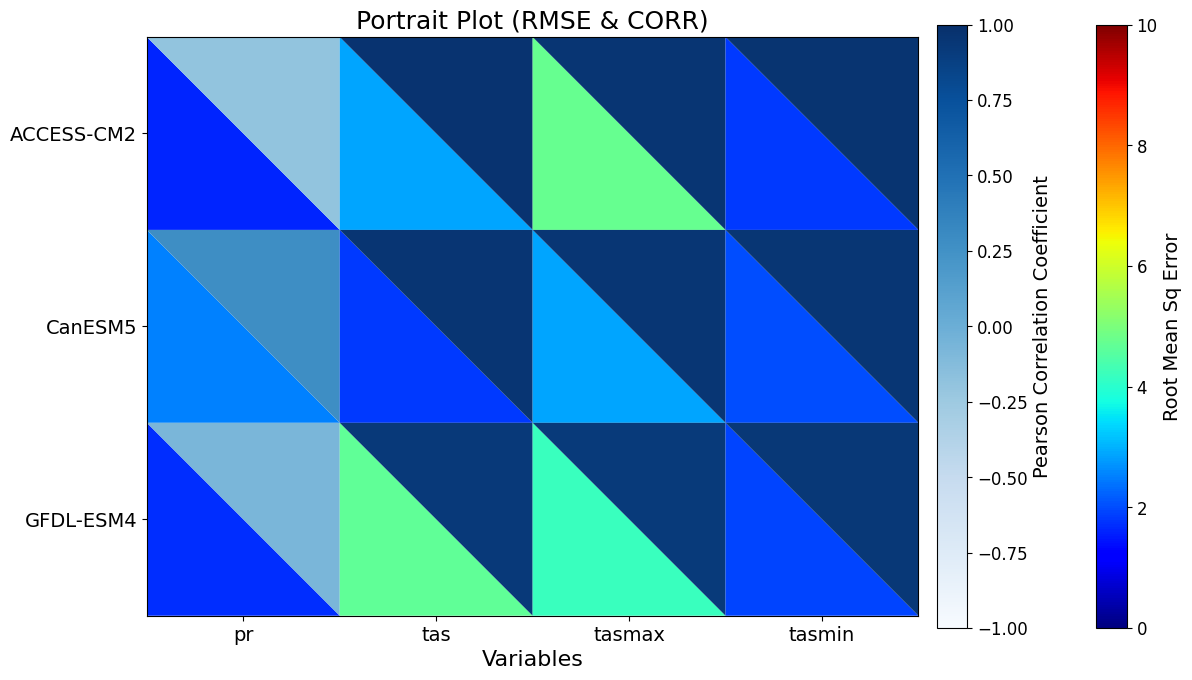

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import matplotlib.cm as cm

rmse = metrics_df.pivot(index="source_id", columns="variable", values="RMSE")
corr = metrics_df.pivot(index="source_id", columns="variable", values="CORR")

models = rmse.index.tolist()
variables = rmse.columns.tolist()

# -------------------------------------------------------
# Colormap and normalization
# -------------------------------------------------------
cmap_rmse = plt.cm.jet
rmse_norm = Normalize(vmin=0, vmax=10)
cmap_corr = plt.cm.Blues
corr_norm = Normalize(vmin=-1, vmax=1)

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

for i, model in enumerate(models):
    for j, var in enumerate(variables):

        x0, x1 = j, j + 1
        y0, y1 = i, i + 1

        # Upper-left triangle (RMSE)
        tri_rmse = Polygon(
            [[x0, y1], [x0, y0], [x1, y1]],
            closed=True,
            facecolor=cmap_rmse(rmse_norm(rmse.loc[model, var])),
            edgecolor="none"
        )
        ax.add_patch(tri_rmse)

        # Lower-right triangle (CORR)
        tri_corr = Polygon(
            [[x1, y0], [x0, y0], [x1, y1]],
            closed=True,
            facecolor=cmap_corr(corr_norm(corr.loc[model, var])),
            edgecolor="none"
        )
        ax.add_patch(tri_corr)

# -------------------------------------------------------
# Axes formatting
# -------------------------------------------------------
ax.set_xticks(np.arange(len(variables)) + 0.5)
ax.set_xticklabels(variables, fontsize=14)

ax.set_yticks(np.arange(len(models)) + 0.5)
ax.set_yticklabels(models, fontsize=14)

ax.set_xlim(0, len(variables))
ax.set_ylim(0, len(models))
ax.invert_yaxis()
ax.set_aspect("equal")

ax.set_xlabel("Variables", fontsize=16)
ax.set_ylabel("", fontsize=16)
ax.set_title("Portrait Plot (RMSE & CORR)", fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=14)

# -------------------------------------------------------
# Colorbars (larger, better spacing)
# -------------------------------------------------------
cbar_rmse = fig.colorbar(
    cm.ScalarMappable(norm=rmse_norm, cmap=cmap_rmse),
    ax=ax,
    fraction=0.05,
    pad=0.02,
    shrink=0.8,
    aspect=20
)
cbar_rmse.set_label("Root Mean Sq Error", fontsize=14)
cbar_rmse.ax.tick_params(labelsize=12)

cbar_corr = fig.colorbar(
    cm.ScalarMappable(norm=corr_norm, cmap=cmap_corr),
    ax=ax,
    fraction=0.15,
    pad=0.02,
    shrink=0.8,
    aspect=20
)
cbar_corr.set_label("Pearson Correlation Coefficient", fontsize=14)
cbar_corr.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()
